<table align="center">
   <td align="center"><a target="_blank" href="https://colab.research.google.com/github/ds5110/summer-2021/blob/master/05c-flights.ipynb">
<img src="https://github.com/ds5110/summer-2021/raw/master/colab.png"  style="padding-bottom:5px;" />Run in Google Colab</a></td>
</table>


# TODO

* Plot average flight delays for destinations on June 13 2013
  * Compare it with another day
* Create a table with a primary key for the flights data.
  * Check for uniqueness, remove duplicates


# 5c -- flights

Case study: [nycflights13 dataset](https://github.com/tidyverse/nycflights13) -- larger multi-table database with ER diagram.

### References

* [R4DS -- Ch 15: Relational data](https://r4ds.had.co.nz/relational-data.html) -- r4ds.had.co.nz
  * Original data source: [Bureau of Transportation Statistics](https://www.bts.gov/) -- bts.gov
* [sqlite3](https://docs.python.org/3/library/sqlite3.html) API reference -- python.org


In [1]:
import sqlite3
import pandas as pd

# From sqlite3 to pandas

* [Reading tables](https://pandas.pydata.org/pandas-docs/stable/user_guide/io.html#reading-tables) -- pandas.pydata.org
* [`pandas.read_sql_table`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_sql_table.html#pandas.read_sql_table) -- pandas.pydata.org
  * SQLAlchemy provides database abstraction if it's installed.
* [`read_sql_table` needs SQLAlchemy](https://pandas.pydata.org/pandas-docs/stable/user_guide/io.html#reading-tables) -- pandas.pydata.org
  * SQLite is in Python’s standard library by default. 
  * You will need a driver library for other databases. 
    * [psycopg2](https://www.psycopg.org/) for PostgreSQL
    * [pymysql](https://github.com/PyMySQL/PyMySQL) for MySQL
* [SQL queries with pandas](https://pandas.pydata.org/pandas-docs/stable/user_guide/io.html#io-sql)
* [write dataframe to sqlite3](https://stackoverflow.com/questions/14431646/how-to-write-pandas-dataframe-to-sqlite-with-index) -- stackoverflow

# Load a database with pandas

* [.to_sql()](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.to_sql.html) API reference docs -- pandas.pydata.org
  * Support is provided for sqlite3.Connection objects. 
  * For another RDBMS, use SQLAlchemy.
* [SQLAlchemy](https://docs.sqlalchemy.org/en/13/core/connections.html)
  * SQLAlchemy makes it possible to use any DB supported by that library. 
  * You are responsible for engine disposal and connection closure when using SQLAlchemy.



## Big data considerations

* Pandas doesn't ["scale" to large datasets](https://pandas.pydata.org/pandas-docs/stable/user_guide/scale.html)
  * Pandas provides data structures for in-memory analytics
  * For large datasets, you need a parallelization strategy and an appropriate tool.
* [Parquet](https://parquet.apache.org/) works when big problems can divided into chunks
    * Each chunk involves a file that fits into memory
* [Dask](https://dask.org/) has a dataframe API similar to Pandas
    * Dask can use multithreading
    * Dask can scale to distribute jobs on clusters
    * Dask is not subject to the Python Global Interpreter Lock (GIL)


# nycflights13 dataset

* flights departing NYC in 2013
* [tidyverse github site](https://github.com/tidyverse/nycflights13/raw/master/data-raw/) -- doesn't have a `flights.csv`
* [R script chat creates flights table](https://github.com/tidyverse/nycflights13/blob/master/data-raw/flights.R) -- github
* The script shows (reproducibly) how to recreate the table.
* The script points to the authoritative data source (bts.gov)
* Infinitely better than simply posting a CSV file!

In [2]:
base = "http://pbogden.github.io/ds5110/data/nycflights13/"
flights = pd.read_csv(base + "flights.csv").drop("Unnamed: 0", axis=1)
airlines = pd.read_csv(base + "airlines.csv").drop("Unnamed: 0", axis=1)
weather = pd.read_csv(base + "weather.csv").drop("Unnamed: 0", axis=1)

flights

,year,month,day,dep_time,sched_dep_time,dep_delay,arr_time,sched_arr_time,arr_delay,carrier,flight,tailnum,origin,dest,air_time,distance,hour,minute,time_hour
0,2013,1,1,517.0,515,2.0,830.0,819,11.0,UA,1545,N14228,EWR,IAH,227.0,1400,5,15,2013-01-01 05:00:00
1,2013,1,1,533.0,529,4.0,850.0,830,20.0,UA,1714,N24211,LGA,IAH,227.0,1416,5,29,2013-01-01 05:00:00
2,2013,1,1,542.0,540,2.0,923.0,850,33.0,AA,1141,N619AA,JFK,MIA,160.0,1089,5,40,2013-01-01 05:00:00
3,2013,1,1,544.0,545,-1.0,1004.0,1022,-18.0,B6,725,N804JB,JFK,BQN,183.0,1576,5,45,2013-01-01 05:00:00
4,2013,1,1,554.0,600,-6.0,812.0,837,-25.0,DL,461,N668DN,LGA,ATL,116.0,762,6,0,2013-01-01 06:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
336771,2013,9,30,NaN,1455,NaN,NaN,1634,NaN,9E,3393,NaN,JFK,DCA,NaN,213,14,55,2013-09-30 14:00:00
336772,2013,9,30,NaN,2200,NaN,NaN,2312,NaN,9E,3525,NaN,LGA,SYR,NaN,198,22,0,2013-09-30 22:00:00
336773,2013,9,30,NaN,1210,NaN,NaN,1330,NaN,MQ,3461,N535MQ,LGA,BNA,NaN,764,12,10,2013-09-30 12:00:00
336774,2013,9,30,NaN,1159,NaN,NaN,1344,NaN,MQ,3572,N511MQ,LGA,CLE,NaN,419,11,59,2013-09-30 11:00:00


In [3]:
flights['origin'].unique()

array(['EWR', 'LGA', 'JFK'], dtype=object)

# EDA of flights

* Interested in flight delays
* Can delays be predicted?
* Q: Is there a dependency between delays & distance?

# EXERCISE -- Predicting delays

* Q: Is there a dependency between delays & distance?
* Q: How might you address this question?

In [4]:
flights.keys()

Index(['year', 'month', 'day', 'dep_time', 'sched_dep_time', 'dep_delay',
       'arr_time', 'sched_arr_time', 'arr_delay', 'carrier', 'flight',
       'tailnum', 'origin', 'dest', 'air_time', 'distance', 'hour', 'minute',
       'time_hour'],
      dtype='object')

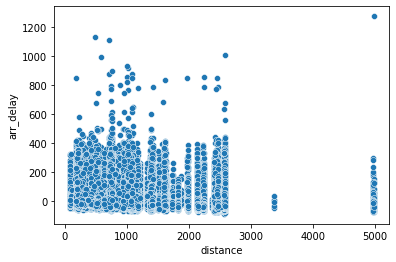

In [5]:
import seaborn as sns

sns.scatterplot(data=flights, x='distance', y='arr_delay');

# Outliers

What's the cause of the two outliers?

In [6]:
# Simple distance filter -- looks like HNL is frequently appearing
flights[flights['distance'] > 3000]

,year,month,day,dep_time,sched_dep_time,dep_delay,arr_time,sched_arr_time,arr_delay,carrier,flight,tailnum,origin,dest,air_time,distance,hour,minute,time_hour
162,2013,1,1,857.0,900,-3.0,1516.0,1530,-14.0,HA,51,N380HA,JFK,HNL,659.0,4983,9,0,2013-01-01 09:00:00
379,2013,1,1,1344.0,1344,0.0,2005.0,1944,21.0,UA,15,N76065,EWR,HNL,656.0,4963,13,44,2013-01-01 13:00:00
1073,2013,1,2,909.0,900,9.0,1525.0,1530,-5.0,HA,51,N380HA,JFK,HNL,638.0,4983,9,0,2013-01-02 09:00:00
1293,2013,1,2,1344.0,1344,0.0,1940.0,1944,-4.0,UA,15,N77066,EWR,HNL,634.0,4963,13,44,2013-01-02 13:00:00
2018,2013,1,3,914.0,900,14.0,1504.0,1530,-26.0,HA,51,N380HA,JFK,HNL,616.0,4983,9,0,2013-01-03 09:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
334536,2013,9,28,1327.0,1329,-2.0,1710.0,1813,-63.0,UA,15,N66057,EWR,HNL,562.0,4963,13,29,2013-09-28 13:00:00
335095,2013,9,29,957.0,1000,-3.0,1405.0,1445,-40.0,HA,51,N384HA,JFK,HNL,580.0,4983,10,0,2013-09-29 10:00:00
335301,2013,9,29,1420.0,1329,51.0,1817.0,1813,4.0,UA,15,N66057,EWR,HNL,569.0,4963,13,29,2013-09-29 13:00:00
336081,2013,9,30,959.0,1000,-1.0,1438.0,1445,-7.0,HA,51,N392HA,JFK,HNL,603.0,4983,10,0,2013-09-30 10:00:00


In [7]:
# Q: Outliers?  A: Two outliers are Hawaii & Alaska
flights[flights['distance'] > 3000]['dest'].unique()

array(['HNL', 'ANC'], dtype=object)

In [8]:
# Create a new dataset without the outliers
flights2 = flights[flights['distance'] < 3000]

flights2.shape

(336061, 19)

# Look at the distribution of the data

* There are over 300K flights
* If there's a relationship, it's not clear from the scatterplot

# Some more insight

* You can get a better look at the data with 2-D histograms.
* [Seaborn joint histogram](https://seaborn.pydata.org/examples/joint_histogram.html)
* Vary the threshold "pmax" (between 0 and 1)

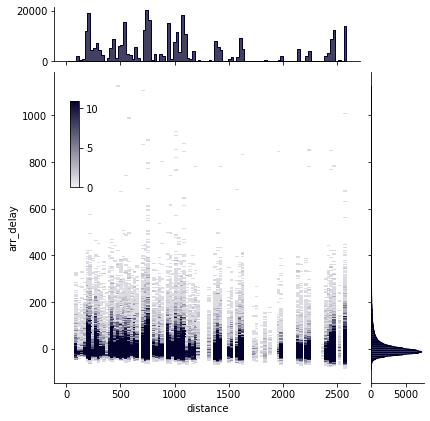

In [9]:
g = sns.JointGrid(data=flights2, x="distance", y="arr_delay", marginal_ticks=True)
cax = g.fig.add_axes([.15, .55, .02, .2]) # left, bottom, width, height
g.plot_joint(
    sns.histplot, discrete=(False, False),
    cmap="light:#03012d", pmax=.1, cbar=True, cbar_ax=cax
)
g.plot_marginals(sns.histplot, element="step", color="#03012d");

# Group by destination

* How about delay vs distance, grouped by destination?
* Ref: [3.08 Aggregation and Grouping](https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/03.08-Aggregation-and-Grouping.ipynb) (VanderPlas) -- github
* GROUP BY is a SQL command, but it's also a split, apply, combine method in Pandas (and R)
* [Seaborn linear regression](https://seaborn.pydata.org/tutorial/regression.html)
* Compare [Chapter 5.6 Grouped Summaries](https://r4ds.had.co.nz/transform.html#grouped-summaries-with-summarise) of "R for Data Science"

In [10]:
grouped = flights2.groupby("dest")

aves = grouped.mean()
counts = grouped.size()

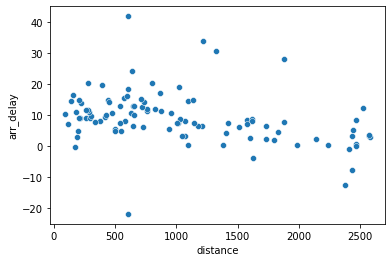

In [11]:
sns.scatterplot(data = aves, x = 'distance', y = 'arr_delay');

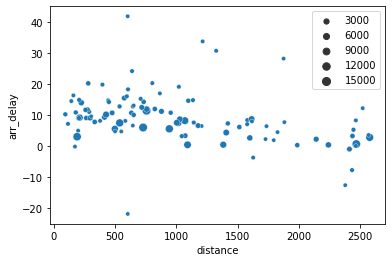

In [12]:
sns.scatterplot(data = aves, x = 'distance', y = 'arr_delay', size=counts)

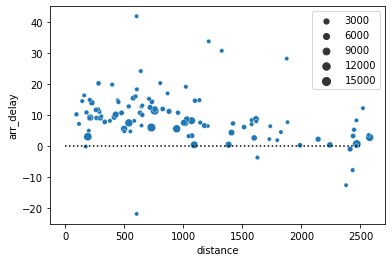

In [13]:
axes = sns.scatterplot(data = aves, x = 'distance', y = 'arr_delay', size=counts)
axes.plot([0, 2500], [0, 0], 'k:');

## Regression plots

Seaborn makes it easy to [Visualize regression models](https://seaborn.pydata.org/tutorial/regression.html)

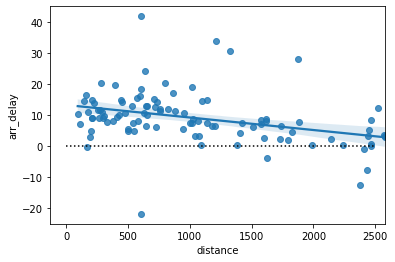

In [14]:
axes = sns.regplot(data = aves, x = 'distance', y = 'arr_delay')
axes.plot([0, 2500], [0, 0], 'k:');

# Group by airplane (tail number)

* Look for individual flights that might be problematic
* Grouping by tail number
* Some planes have an average 5-hour delays!?

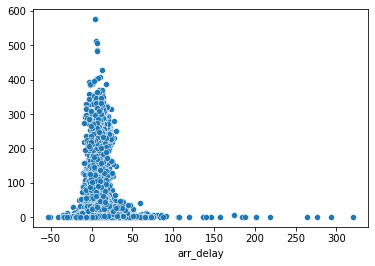

In [15]:
grouped2 = flights2.groupby("tailnum")

aves = grouped2.mean()
counts = grouped2.size()

sns.scatterplot(x = aves['arr_delay'], y = counts);

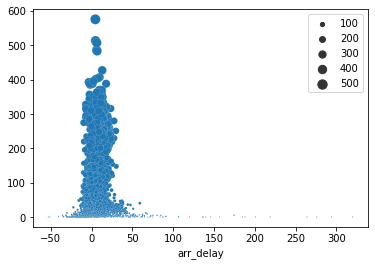

In [16]:
# Adding information about counts 
# This shows that this large average delays are for very small sample size
grouped2 = flights2.groupby("tailnum")

aves = grouped2.mean()
counts = grouped2.size()

sns.scatterplot(x = aves['arr_delay'], y = counts, size=counts, sizes=(1, 100));

# Get the rest of the data

In [17]:

base = "https://github.com/tidyverse/nycflights13/raw/master/data-raw/"
airlines = pd.read_csv(base + "airlines.csv")
airports = pd.read_csv(base + "airports.csv")
planes = pd.read_csv(base + "planes.csv")
weather = pd.read_csv(base + "weather.csv")
print(airlines)
print(airports)
print(planes)
print(weather)

   carrier                         name
0       9E            Endeavor Air Inc.
1       AA       American Airlines Inc.
2       AS         Alaska Airlines Inc.
3       B6              JetBlue Airways
4       DL         Delta Air Lines Inc.
5       EV     ExpressJet Airlines Inc.
6       F9       Frontier Airlines Inc.
7       FL  AirTran Airways Corporation
8       HA       Hawaiian Airlines Inc.
9       MQ                    Envoy Air
10      OO        SkyWest Airlines Inc.
11      UA        United Air Lines Inc.
12      US              US Airways Inc.
13      VX               Virgin America
14      WN       Southwest Airlines Co.
15      YV           Mesa Airlines Inc.
      faa                           name        lat  ...  tz  dst             tzone
0     04G              Lansdowne Airport  41.130472  ...  -5    A  America/New_York
1     06A  Moton Field Municipal Airport  32.460572  ...  -6    A   America/Chicago
2     06C            Schaumburg Regional  41.989341  ...  -6    A   

In [18]:
# Load all tables into the database
!rm -f nycflights13.db # start fresh, in case this cell gets run twice

connection = sqlite3.connect('nycflights13.db')

airports.to_sql(name='airports', con=connection)
planes.to_sql(name='planes', con=connection)
airlines.to_sql(name='airlines', con=connection)
weather.to_sql(name='weather', con=connection)
flights.to_sql(name='flights', con=connection)


In [19]:
# List the table names
sql = "SELECT name FROM sqlite_master WHERE type='table';"
with sqlite3.connect('nycflights13.db') as db:
  table = pd.read_sql_query(sql, db)
  print(table)

# Confirm the open database connections
! lsof nycflights13.db

       name
0  airports
1    planes
2  airlines
3   weather
4   flights
COMMAND PID USER   FD   TYPE DEVICE SIZE/OFF    NODE NAME
python3  61 root   64u   REG   0,51 36446208 4850814 nycflights13.db
python3  61 root   65u   REG   0,51 36446208 4850814 nycflights13.db


# Relational data

* ER (Entity Relationship) model
* ERD (Entity Relationship Diagram)
* Each entity (box) represents a table in the RDBMS
* Connecting arrows and symbols describe the table relationships
  * `flights` connects to `planes` via `tailnum`
  * `flights` connects to `airlines` via `carrier`
  * `flights` connects to `airports` via 2 variables:
    * `origin` and `dest`
  * `flights` connects to `weather` via location and time:
    * location via `origin`
    * time via `year`, `month`, `day`, `hour`

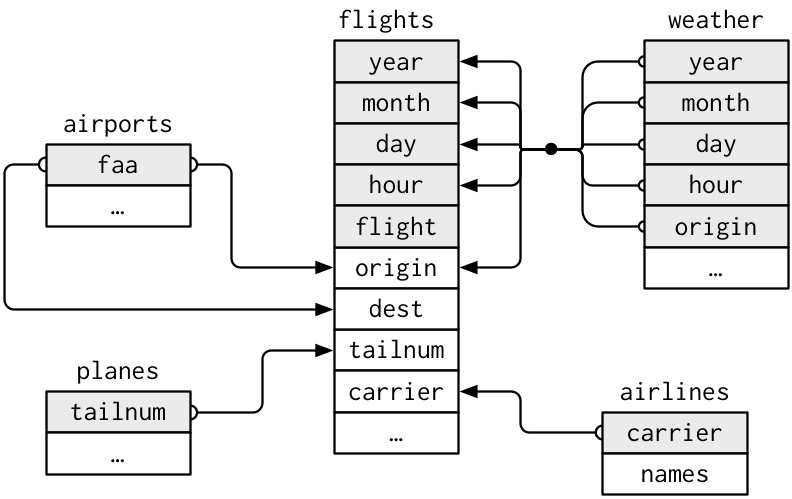

## Keys

* Keys connect pairs of tables
* A key is a variable or set of variables that uniquely identifies an observation (tuple).
* For example...
  * Each plane (i.e., observation of `planes`) is uniquely identified by its `tailnum`
  * Each unique `weather` observation requires 5 variables (1 for origin and 4 for time)
* There are two types of keys...
  * **primary key** uniquely identifies an observation in its table
  * For example, `tailnum` is a primary key for each plane in the `planes` table
  * **foreign key** identifies an observation in another table
  * For example, `tailnum` in `flights` is a foreign key for `flight` in the `planes` table
* Variables can be both primary and foreign keys, for example...
  * `origin` is part of a primary key for `weather` table
  * `origin` is also the foreign key for the `airports` table
* Typically, you define primary and foreign key "constraints" when you create the database.
  * A `PRIMARY KEY` constraint uniquely identifies each record in a table.
    * Primary keys must contain `UNIQUE` values, and cannot contain `NULL` values.
    * A table can have only `ONE` primary key
    * A primary key can consist of one or multiple columns (fields).
  * A `FOREIGN KEY` constraint prevents actions that would destroy links between tables.
    * A foreign key is a field (or collection of fields) in one table that refers to the `PRIMARY KEY` in another table.
    * The table with the foreign key is called the child table,
    * The table with the primary key is called the referenced or parent table.



# Views

* A "view" is a virtual table based on the result-set of an SQL statement.
* A view contains rows and columns, just like a real table. 
  * The fields in a view are fields from one or more tables in the database.
  * But unlike a real table, a view takes no memory.
  * The only thing stored is the relation that defines the view.
* You can add SQL statements and functions to a view.
  * The result-set behaves as if the data were coming from one single table.

A view is created with the CREATE VIEW statement. 


In [20]:
# Create a view with a subset of the flights table
query_string = "CREATE VIEW IF NOT EXISTS flights2 AS"
query_string += " SELECT year, month, day, hour, origin, dest, tailnum, carrier"
query_string += " FROM flights"
query_string += ";"
with sqlite3.connect('nycflights13.db') as db:
  cursor = db.cursor()
  cursor.execute(query_string)
  db.commit()

In [21]:
# Verify that the view is there
with sqlite3.connect('nycflights13.db') as db:
  table = pd.read_sql_query("SELECT * from sqlite_master WHERE type='table'", db)
  print(table)
  view = pd.read_sql_query("SELECT * from sqlite_master WHERE type='view'", db)

view

    type      name  ... rootpage                                                sql
0  table  airports  ...        2  CREATE TABLE "airports" (\n"index" INTEGER,\n ...
1  table    planes  ...       36  CREATE TABLE "planes" (\n"index" INTEGER,\n  "...
2  table  airlines  ...      112  CREATE TABLE "airlines" (\n"index" INTEGER,\n ...
3  table   weather  ...      114  CREATE TABLE "weather" (\n"index" INTEGER,\n  ...
4  table   flights  ...      797  CREATE TABLE "flights" (\n"index" INTEGER,\n  ...

[5 rows x 5 columns]


,type,name,tbl_name,rootpage,sql
0,view,flights2,flights2,0,"CREATE VIEW flights2 AS SELECT year, month, da..."


## EXERCISE

Q: Can the grayed columns serve as a primary key for the flights table?

In [22]:
# First, remember how to count True values. Recall from notebook: 05b-rdbms.ipynb
s = pd.Series([False, True, True]).sum()
s

2

In [23]:
# Then check for the number of duplicated combinations -- there are 2,945
# You can't use year, month, day, hour and flight as a primary key for flights
flights[['year', 'month', 'day', 'hour', 'flight']].duplicated().sum()

2945

# Joins

There are three families of verbs for working with multiple tables of related (relational) data...

* Mutating joins
* Filtering joins
* Set operations





## Mutating Joins

* Combines variables from two tables
* First match observations by common keys
* Then copy variables to another table


In [24]:
# First, we SELECT a subset of the columns FROM the flights table
query_string = "SELECT * from flights2;"

with sqlite3.connect('nycflights13.db') as db:
  cursor = db.cursor()
  cursor.execute(query_string)
  flights2 = pd.read_sql_query(query_string, db)

print(query_string)
flights2

SELECT * from flights2;


,year,month,day,hour,origin,dest,tailnum,carrier
0,2013,1,1,5,EWR,IAH,N14228,UA
1,2013,1,1,5,LGA,IAH,N24211,UA
2,2013,1,1,5,JFK,MIA,N619AA,AA
3,2013,1,1,5,JFK,BQN,N804JB,B6
4,2013,1,1,6,LGA,ATL,N668DN,DL
...,...,...,...,...,...,...,...,...
336771,2013,9,30,14,JFK,DCA,None,9E
336772,2013,9,30,22,LGA,SYR,None,9E
336773,2013,9,30,12,LGA,BNA,N535MQ,MQ
336774,2013,9,30,11,LGA,CLE,N511MQ,MQ


# EXERCISE

Create a view that adds the full name of the airline to the flights data.

In [25]:
query_string = "SELECT year, month, day, hour, origin, dest, tailnum,"
query_string += " flights.carrier, name"
# query_string += " carrier, name" # What happens if you use this instead?
query_string += " FROM flights"
query_string += " LEFT JOIN airlines"
query_string += " ON flights.carrier = airlines.carrier"
query_string += ";"

with sqlite3.connect('nycflights13.db') as db:
  flights2 = pd.read_sql_query(query_string, db)

flights2

,year,month,day,hour,origin,dest,tailnum,carrier,name
0,2013,1,1,5,EWR,IAH,N14228,UA,United Air Lines Inc.
1,2013,1,1,5,LGA,IAH,N24211,UA,United Air Lines Inc.
2,2013,1,1,5,JFK,MIA,N619AA,AA,American Airlines Inc.
3,2013,1,1,5,JFK,BQN,N804JB,B6,JetBlue Airways
4,2013,1,1,6,LGA,ATL,N668DN,DL,Delta Air Lines Inc.
...,...,...,...,...,...,...,...,...,...
336771,2013,9,30,14,JFK,DCA,None,9E,Endeavor Air Inc.
336772,2013,9,30,22,LGA,SYR,None,9E,Endeavor Air Inc.
336773,2013,9,30,12,LGA,BNA,N535MQ,MQ,Envoy Air
336774,2013,9,30,11,LGA,CLE,N511MQ,MQ,Envoy Air


# Weather impact

* Q: What is the weather impact on delays? What questions can we ask with this dataset?



# EXERCISE

Q: Where do we have weather information?

A: 
  * DISTINCT origin -- only have data for departing airports (JFK, Laguardia, Newark)
  * DISTINCT "precip" -- a range of values with a couple extremes exceeding 1
  * TRY: scatterplot of departure delay vs precip
    * left outer join of flights with weather.precip



In [26]:
sql = "SELECT DISTINCT origin FROM weather;"

pd.read_sql_query(sql, connection)

,origin
0,EWR
1,JFK
2,LGA


In [27]:
# How much information is there about precipitation?
# Real-valued -- ~50 different measurement values in the dataset (2013)
# sql = "SELECT precip FROM weather;"

# pd.read_sql_query(sql, connection)

In [28]:
sql = '''SELECT dep_delay, precip
      FROM flights
      LEFT JOIN weather
      ON flights.year = weather.year
      AND flights.month = weather.month
      AND flights.day = weather.day
      AND flights.hour = weather.hour
      AND flights.hour = weather.hour
      AND precip < .5;'''

df = pd.read_sql_query(sql, connection)
df

,dep_delay,precip
0,2.0,0.0
1,2.0,0.0
2,2.0,0.0
3,4.0,0.0
4,4.0,0.0
...,...,...
1006393,NaN,0.0
1006394,NaN,0.0
1006395,NaN,0.0
1006396,NaN,0.0


In [29]:
flights.keys()

Index(['year', 'month', 'day', 'dep_time', 'sched_dep_time', 'dep_delay',
       'arr_time', 'sched_arr_time', 'arr_delay', 'carrier', 'flight',
       'tailnum', 'origin', 'dest', 'air_time', 'distance', 'hour', 'minute',
       'time_hour'],
      dtype='object')

In [30]:
weather.keys()

Index(['origin', 'year', 'month', 'day', 'hour', 'temp', 'dewp', 'humid',
       'wind_dir', 'wind_speed', 'wind_gust', 'precip', 'pressure', 'visib',
       'time_hour'],
      dtype='object')

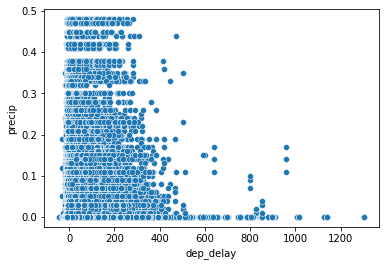

In [31]:
sns.scatterplot(data=df, x='dep_delay', y='precip');

# Distribution

* The scatterplot doesn't provide any insights
* It does start showing gaps for higher values of precip
* This is another situation where extremes have fewer samples
* Q: Do high and low precip have different distributions?
* A: Compare 2-D histograms for high and low precip
  * This shows that high precip is definitely associated with delays
  * But they're low probability events
  * So you'll have to dig deeper to explain bulk of delays

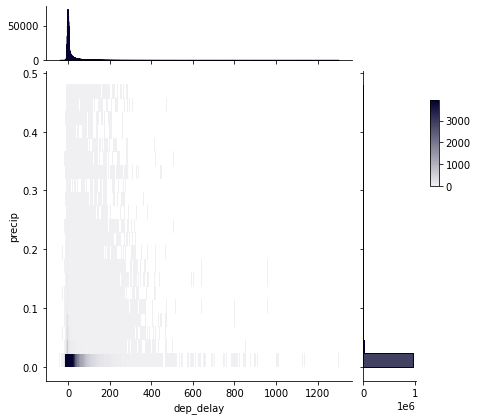

In [32]:
g = sns.JointGrid(data=df, x="dep_delay", y="precip", marginal_ticks=True)
cax = g.fig.add_axes([1., .55, .02, .2]) # left, bottom, width, height
g.plot_joint(
    sns.histplot, discrete=(False, False),
    cmap="light:#03012d", pmax=.2, cbar=True, cbar_ax=cax
)
g.plot_marginals(sns.histplot, element="step", color="#03012d");

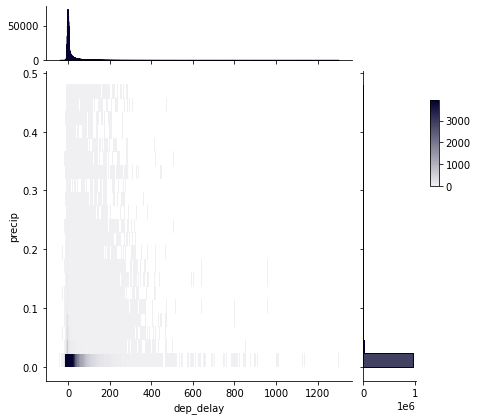

In [33]:
g = sns.JointGrid(data=df, x="dep_delay", y="precip", marginal_ticks=True)
cax = g.fig.add_axes([1., .55, .02, .2]) # left, bottom, width, height
g.plot_joint(
    sns.histplot, discrete=(False, False),
    cmap="light:#03012d", pmax=.2, cbar=True, cbar_ax=cax
)
g.plot_marginals(sns.histplot, element="step", color="#03012d");

# Airport altitudes with d3-geo

* [pandas.DataFrame.apply](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.apply.html)

In [34]:
airports

,faa,name,lat,lon,alt,tz,dst,tzone
0,04G,Lansdowne Airport,41.130472,-80.619583,1044,-5,A,America/New_York
1,06A,Moton Field Municipal Airport,32.460572,-85.680028,264,-6,A,America/Chicago
2,06C,Schaumburg Regional,41.989341,-88.101243,801,-6,A,America/Chicago
3,06N,Randall Airport,41.431912,-74.391561,523,-5,A,America/New_York
4,09J,Jekyll Island Airport,31.074472,-81.427778,11,-5,A,America/New_York
...,...,...,...,...,...,...,...,...
1453,ZUN,Black Rock,35.083228,-108.791778,6454,-7,A,America/Denver
1454,ZVE,New Haven Rail Station,41.298669,-72.925992,7,-5,A,America/New_York
1455,ZWI,Wilmington Amtrak Station,39.736667,-75.551667,0,-5,A,America/New_York
1456,ZWU,Washington Union Station,38.897460,-77.006430,76,-5,A,America/New_York


In [35]:
# Import observable-jupyter
!pip install observable_jupyter
from observable_jupyter import embed

In [50]:
source = airports.apply(lambda x: {'id': x.faa,
                                   'location': [x.lon, x.lat],
                                   'title': x.faa,
                                   'value': x.alt}, axis=1)
print(source[0])
print(len(source))
print(type(source))
# [{'id': 0, 'title': 'San Francisco', 'location': [-122.4194, 37.7749], 'value': 10}]
source

{'id': '04G', 'location': [-80.6195833, 41.1304722], 'title': '04G', 'value': 1044}
1458
<class 'pandas.core.series.Series'>


0       {'id': '04G', 'location': [-80.6195833, 41.130...
1       {'id': '06A', 'location': [-85.68002779999999,...
2       {'id': '06C', 'location': [-88.1012428, 41.989...
3       {'id': '06N', 'location': [-74.39156109999999,...
4       {'id': '09J', 'location': [-81.42777779999999,...
                              ...                        
1453    {'id': 'ZUN', 'location': [-108.79177800000001...
1454    {'id': 'ZVE', 'location': [-72.92599200000001,...
1455    {'id': 'ZWI', 'location': [-75.55166700000001,...
1456    {'id': 'ZWU', 'location': [-77.00643000000001,...
1457    {'id': 'ZYP', 'location': [-73.9935, 40.7505],...
Length: 1458, dtype: object

In [37]:
embed('@pbogden/bubble-map-jupyter', cells=['chart', 'data'], inputs={'source': list(source), 'max': 15000})

## Spike map

Don't like the bubble map?  Then how about a spike map?

In [52]:
embed('@pbogden/spike-map-jupyter', cells=['chart', 'data'], inputs={'source': list(source), 'max': 20000})

# June 13th derechos

In [39]:
flights.iloc[0, :]

year                             2013
month                               1
day                                 1
dep_time                          517
sched_dep_time                    515
dep_delay                           2
arr_time                          830
sched_arr_time                    819
arr_delay                          11
carrier                            UA
flight                           1545
tailnum                        N14228
origin                            EWR
dest                              IAH
air_time                          227
distance                         1400
hour                                5
minute                             15
time_hour         2013-01-01 05:00:00
Name: 0, dtype: object

In [40]:

jun13 = flights[(flights['month'] == 6) & (flights['day'] == 13)]
#jun13 = flights[(flights['month'] == 2) & (flights['day'] == 1)]
jun13 = jun13.groupby('dest')
jun13 = jun13.mean('arr_delay')
jun13 = jun13.dropna()

In [41]:
airports[airports.faa == 'BQN']

,faa,name,lat,lon,alt,tz,dst,tzone


In [42]:
source = jun13.apply(lambda x: {'id': x.name,
   # 'location': list(airports[airports.faa == x.name][['lon', 'lat']].values[0]),
    'location': airports[airports.faa == x.name],
    'title': x.name,
    'value': x.arr_delay}, axis=1)

source = []
for i, x in jun13.iterrows():
  airport = airports[airports.faa == i]
  if airport.empty:
    print('skipping', i)
    continue
  datum = {'id': x.name,
    'location': list(airport[['lon', 'lat']].values[0]),
    'title': x.name,
    'value': x.arr_delay }
  source.append(datum)

skipping BQN
skipping PSE
skipping SJU
skipping STT


In [44]:
embed('@pbogden/bubble-map-jupyter', cells=['chart', 'data'], inputs={'source': source, 'max': 120, 'w': "500px"})

# A different day

In [49]:
jan1 = flights[(flights['month'] == 2) & (flights['day'] == 1)]
jan1 = jan1.groupby('dest')
jan1 = jan1.mean('arr_delay')
jan1 = jan1.dropna()

source = jan1.apply(lambda x: {'id': x.name,
   # 'location': list(airports[airports.faa == x.name][['lon', 'lat']].values[0]),
    'location': airports[airports.faa == x.name],
    'title': x.name,
    'value': x.arr_delay}, axis=1)

source = []
for i, x in jan1.iterrows():
  airport = airports[airports.faa == i]
  if airport.empty:
    print('skipping', i)
    continue
  datum = {'id': x.name,
    'location': list(airport[['lon', 'lat']].values[0]),
    'title': x.name,
    'value': x.arr_delay }
  source.append(datum)

embed('@pbogden/bubble-map-jupyter', cells=['chart', 'data'], inputs={'source': source, 'max': 120, 'w': "500px"})

skipping BQN
skipping PSE
skipping SJU
skipping STT
